In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Import data

In [2]:
dat = pd.read_csv("../data/ATP.csv")

# convert date as datatime

In [3]:
dat['date'] = dat.tourney_date.apply(lambda t: datetime.strptime(str(t), '%Y%m%d'))

# change format of initial dataframe

In [4]:
colnames = dict()
colnames['type1'] = ['1stIn', '1stWon', '2ndWon', 'SvGms', 'ace', 'bpFaced', 'bpSaved', 'df', 'svpt']
colnames['type2'] = ['age', 'entry', 'hand', 'ht', 'id', 'ioc', 'name', 'rank', 'rank_points', 'seed']
colnames['type3'] = ['best_of', 'draw_size', 'match_num', 'minutes', 'round', 'score', 'surface', 'tourney_date',
                     'tourney_id', 'tourney_level', 'tourney_name', 'date']

In [5]:
df = pd.DataFrame()
mat = []
for i in dat.index:
    row = []
    for col in colnames['type3']:
        row.append(dat[col][i])
    if i % 2 == 0: #j0
        # j0=loser, j1=winner
        for col in colnames['type1']:
            row.append(dat['l_'+col][i])
        for col in colnames['type2']:
            row.append(dat['loser_'+col][i])
        for col in colnames['type1']:
            row.append(dat['w_'+col][i])
        for col in colnames['type2']:
            row.append(dat['winner_'+col][i])
        row.append(1) #target winner --> j1
    else: #j1
        # j0=winner, j1=loser
        for col in colnames['type1']:
            row.append(dat['w_'+col][i])
        for col in colnames['type2']:
            row.append(dat['winner_'+col][i])
        for col in colnames['type1']:
            row.append(dat['l_'+col][i])
        for col in colnames['type2']:
            row.append(dat['loser_'+col][i])
        row.append(0) #target winner --> j0
    mat.append(row)

In [6]:
colDataFrame = colnames['type3']
for col in colnames['type1']:
    colDataFrame.append('j0_'+col)
for col in colnames['type2']:
    colDataFrame.append('j0_'+col)
for col in colnames['type1']:
    colDataFrame.append('j1_'+col)
for col in colnames['type2']:
    colDataFrame.append('j1_'+col)
colDataFrame.append("target")

In [7]:
df = pd.DataFrame(columns=colDataFrame, data=mat)

In [8]:
df.to_csv("../data/ATP_.csv", sep=";", index=False)

# Exploration of data

In [82]:
dateparse = lambda x:datetime.strptime(x,'%Y-%m-%d').date()

In [83]:
df = pd.read_csv("../data/ATP_.csv", sep=";")
print("nRows : {}, nCols : {}".format(df.shape[0], df.shape[1]))

nRows : 169690, nCols : 51


In [85]:
df['date'] = df['date'].apply(dateparse)

In [219]:
dfe = df.copy()

The first rankings were published in August, 23rd 1973, so we can delete all row without rank as this value seems to be important for the bookmakers !

In [220]:
dfe = dfe.loc[np.invert(dfe.j0_rank.isna()) & np.invert(dfe.j1_rank.isna())]
dfe = dfe.loc[np.invert(dfe.j0_rank_points.isna()) & np.invert(dfe.j1_rank_points.isna())]
dfe = dfe.loc[np.invert(dfe.surface.isna())]
dfe = dfe.loc[np.invert(dfe.j0_age.isna()) & np.invert(dfe.j1_age.isna())]

In [221]:
print("There are {} matches since {}".format(dfe.shape[0], dfe.date[0:1]))
print("There are {} different players".format(len(list(set(dfe.j0_name + dfe.j1_name)))))

There are 92327 matches since 73120   1990-01-01
Name: date, dtype: datetime64[ns]
There are 62573 different players


In [222]:
dfe.surface.unique()

array(['Hard', 'Grass', 'Carpet', 'Clay', 'None'], dtype=object)

In [223]:
dfe.groupby(["surface"])["surface"].count()

surface
Carpet     7415
Clay      31048
Grass      9134
Hard      44674
None         56
Name: surface, dtype: int64

In [224]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(dfe.surface)
print(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

onehot_encoder.feature_indices_

[3 3 3 ... 1 1 1]
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


array([0, 5], dtype=int32)

In [267]:
df_surface = dfe.surface.str.get_dummies()

In [268]:
df_surface.head()

,Carpet,Clay,Grass,Hard,None
73120,0,0,0,1,0
73121,0,0,0,1,0
73122,0,0,0,1,0
73123,0,0,0,1,0
73124,0,0,0,1,0


# Model

In [269]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,roc_auc_score
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns
class logisticRegression:
    def __init__(self,data,seed,random_sample):
        self.random_sample = random_sample
        self.seed = seed
        
        self.data = data.sample(frac=self.random_sample, replace=False, random_state=self.seed)
        
        self.lr=None
        self.pred_train=None
        self.pred_test=None
    def split(self, test_size):
        self.test_size = test_size
        train_X, test_X, train_y, test_y = train_test_split(self.data,self.data['target'], test_size = test_size, random_state=self.seed)
        self.train_X = train_X.drop(columns=['target'])
        self.test_X = test_X.drop(columns=['target'])
        self.train_y = train_y
        self.test_y = test_y
    def model(self,n_jobs,cv,regul):
        self.regul = regul
        if regul=='none':
            n_iters = np.array([50, 200])
            model = linear_model.SGDClassifier(loss='log', random_state=0, penalty=self.regul)
            grid = GridSearchCV(estimator=model, param_grid=dict(n_iter=n_iters), scoring='roc_auc', n_jobs=n_jobs, cv=cv, verbose=1)
            grid.fit(self.train_X,self.train_y)
            self.lr = grid
        elif regul=='elasticnet':
            n_iters = np.array([50, 200])
            alphas = np.logspace(-5, 1, 5)
            l1_ratios = np.array([0, 0.15, 0.3, 0.4, 0.5, 0.6, 0.85, 1])
            model = linear_model.SGDClassifier(loss='log', random_state=0, penalty=self.regul,n_iter=100,max_iter=100)
            grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas,l1_ratio=l1_ratios), scoring='roc_auc', n_jobs=n_jobs, cv=cv, verbose=1)
            grid.fit(self.train_X,self.train_y)
            self.lr = grid
        return self.lr
    def predict(self):
        self.pred_train = self.lr.best_estimator_.predict(X=self.train_X)
        self.pred_test = self.lr.best_estimator_.predict(X=self.test_X)
    def get_AUC(self):
        self.train_auc=metrics.roc_auc_score(y_score=self.lr.best_estimator_.predict_proba(X=self.train_X)[:,1], y_true=self.train_y)
        self.test_auc=metrics.roc_auc_score(y_score=self.lr.best_estimator_.predict_proba(X=self.test_X)[:,1], y_true=self.test_y)
        return (self.train_auc,self.test_auc)
    ### get contingency table + recall precision + roc curve !!!
    def boxplot(self):
        plt.figure()
        plt.subplot(1,2,1)
        sns.boxplot(x=self.train_y.values, y=self.lr.best_estimator_.predict_proba(X=self.train_X.values)[:,1])
        plt.title('Train')
        plt.subplot(1,2,2)
        sns.boxplot(x=self.test_y.values, y=self.lr.best_estimator_.predict_proba(X=self.test_X.values)[:,1])
        plt.title('Test')
        return plt
    def rocCurve(self):
        plt.figure()
        plt.subplot(1,2,1)
        fpr, tpr, thresholds = metrics.roc_curve(y_score=self.lr.best_estimator_.predict_proba(X=self.train_X)[:,1], y_true=self.train_y)
        plt.plot(fpr, tpr,'r')
        plt.plot([0,1],[0,1],'b')
        plt.title('Train, AUC: {}'.format(round(metrics.auc(fpr,tpr),3)))
        
        plt.subplot(1,2,2)
        fpr, tpr, thresholds = metrics.roc_curve(y_score=self.lr.best_estimator_.predict_proba(X=self.test_X)[:,1], y_true=self.test_y)
        plt.plot(fpr, tpr,'r')
        plt.plot([0,1],[0,1],'b')
        plt.title('Test, AUC: {}'.format(round(metrics.auc(fpr,tpr),3)))
        return plt
    def confusion(self,set_):
        if set_ == "train":
            res = metrics.confusion_matrix(y_true=self.train_y,y_pred=self.pred_train)
        elif set_ == "test":
            res = metrics.confusion_matrix(y_true=self.test_y,y_pred=self.pred_test)
        return res
    def getAccuracy(self):
        res=(metrics.accuracy_score(y_true=self.train_y,y_pred=self.pred_train),
            metrics.accuracy_score(y_true=self.test_y,y_pred=self.pred_test))
        return res
    def getClassificationReport(self,set_):
        if set_ == "train":
            res = metrics.classification_report(self.train_y, self.pred_train)
        elif set_ == "test":
            res = metrics.classification_report(self.test_y, self.pred_test)
        return res

In [272]:
dfm = dfe[["target","j0_rank_points","j1_rank_points","j0_age","j1_age"]]
dfm[df_surface.columns] = df_surface
dfm.head()

C:\Users\HAZRAK\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,target,j0_rank_points,j1_rank_points,j0_age,j1_age,Carpet,Clay,Grass,Hard,None
73120,1,70.0,591.0,20.40,18.96,0,0,0,1,0
73121,0,157.0,182.0,29.00,25.01,0,0,0,1,0
73122,1,290.0,215.0,23.90,21.20,0,0,0,1,0
73123,0,297.0,271.0,30.23,21.94,0,0,0,1,0
73124,1,224.0,496.0,22.35,22.25,0,0,0,1,0


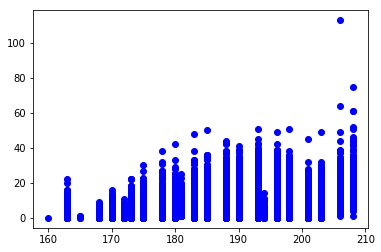

In [273]:
sum(dfe.j0_ace.isna())
_=plt.scatter(dfe.j0_ht, dfe.j0_ace, c='blue')

In [293]:
lr = logisticRegression(data=dfm,seed=9,random_sample=0.5)
lr.split(0.4)

In [294]:
lr.model(cv=4,n_jobs=4,regul="elasticnet")

Fitting 4 folds for each of 40 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:   36.8s finished
C:\Users\HAZRAK\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


GridSearchCV(cv=4, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=100, n_iter=100,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=0,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'alpha': array([1.00000e-05, 3.16228e-04, 1.00000e-02, 3.16228e-01, 1.00000e+01]), 'l1_ratio': array([0.  , 0.15, 0.3 , 0.4 , 0.5 , 0.6 , 0.85, 1.  ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [295]:
lr.predict()

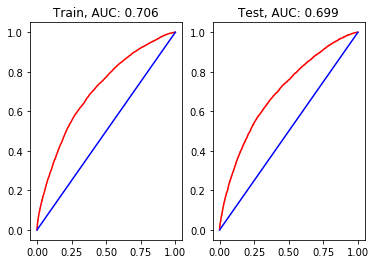

In [296]:
_ = lr.rocCurve()

In [297]:
lr.lr.best_params_

{'alpha': 10.0, 'l1_ratio': 0.15}

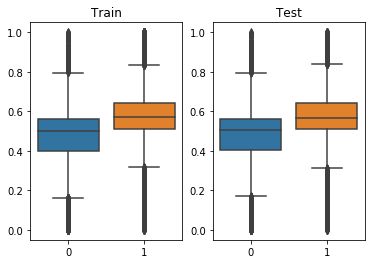

In [298]:
_ = lr.boxplot()